This is a script for probing the capabilities of the rectv algorithm by Nikitin. This script should be run with py39 conda environment. First lets load some packages we need. 

In [9]:
import rectv_gpu
import numpy as np
import dxchange
import matplotlib.pyplot as plt
import ipywidgets as widgets
from os import listdir
from os.path import join
from ImageSliceViewer3D import *
import tomopy

I have used the script in PhantomGenerato "xraysim.py" to simulate some dynamic data. The data generation has a bit of a finicky problem requiring some transposing for the data to work. Good thing is that the blender file can be changed to create more/less motion. We can run the simulation like this: blender input/particle_test.blend --frame-start 1 --frame-end 180 -o output/Simulation/ --background --python xraysim.py -- --numberofangles 180 --anglesperframe 1 -n Empty


In [23]:
filepath = filepath = "../PhantomGenerator/output/slow_fast"
files = [file for file in np.sort(listdir(filepath)) if file.endswith(".npy")]
height, width = np.load(join(filepath,files[0])).shape
depth = len(files)
volume = np.zeros((depth, height, width))
for i,file in enumerate(files):
    volume[i,:,:] = np.load(join(filepath,file))

volume = volume.astype('float32')
#Need a bit of trasposing for the data to work....
#data = np.swapaxes(volume, 1,2)
data = np.swapaxes(volume, 1,0)#[200:250]
[nz, ntheta, n] = data.shape
nz, ntheta, n

(512, 240, 512)

ImageSliceViewer can be used to view the data. You can see it once you up the slice number

In [24]:
ImageSliceViewer3D(data)

In [14]:
rot_center = n//2

In [15]:
#print(theta[100:200])
theta = np.linspace(0, 8*np.pi, ntheta, endpoint=False).astype('float32')

By using tomopy for reconstruction we see that static parts are reconstructed but moving particle is causing artifacts.

In [6]:
recon = tomopy.recon(np.swapaxes(data, 0,1), theta, center=rot_center, algorithm='fbp', ncore=32)
ImageSliceViewer3D(recon)

We could try and load rectv test data just to see how this works with tomopy gridrec - it will also give us an understandig of how the data is indexed

In [7]:
def takephi(ntheta):
    m = 8 # number of basis functions
    [x, y] = np.meshgrid(np.arange(-ntheta//2, ntheta//2), np.arange(-m//2, m//2))
    phi = np.zeros([m, 2*ntheta], dtype='float32')
    phi[:, ::2] = np.cos(2*np.pi*x*y/ntheta)/np.sqrt(ntheta)
    phi[:, 1::2] = np.sin(2*np.pi*x*y/ntheta)/np.sqrt(ntheta)
    return phi

In [8]:
#lambda0 = 1e-3  # regularization parameter 1
#lambda1 = 1  #regularization parameter 2

In [9]:
niter = 32  # number of ADMM iterations
titer = 4  # number of inner tomography iterations

In [10]:
nzp = 4 # number of slices to process simultaniously by gpu
ngpus = 1 # number of gpus

In [11]:
phi = takephi(ntheta) 
m = phi.shape[0] # number of basis functions
phi, m

(array([[ 6.4549722e-02, -1.4628358e-16,  6.4196110e-02, ...,
          1.3420642e-02,  6.4196110e-02,  6.7472835e-03],
        [-6.4549722e-02,  1.3837853e-16, -6.4350739e-02, ...,
         -1.0097802e-02, -6.4350739e-02, -5.0645131e-03],
        [ 6.4549722e-02, -7.3141791e-17,  6.4461261e-02, ...,
          6.7472835e-03,  6.4461261e-02,  3.3782714e-03],
        ...,
        [-6.4549722e-02, -3.6570896e-17, -6.4527601e-02, ...,
          3.3782714e-03, -6.4527601e-02,  1.6897147e-03],
        [ 6.4549722e-02,  7.3141791e-17,  6.4461261e-02, ...,
         -6.7472835e-03,  6.4461261e-02, -3.3782714e-03],
        [-6.4549722e-02, -1.3837853e-16, -6.4350739e-02, ...,
          1.0097802e-02, -6.4350739e-02,  5.0645131e-03]], dtype=float32),
 8)

In [12]:
cl = rectv_gpu.Solver(n, ntheta, m, nz, nzp, ngpus)

In [13]:
#try varying the last arguments
rtv = cl.recon(data, theta, phi, rot_center=rot_center, niter=200, titer=4,lambda0=1e-2, lambda1=150)

iter (0/200), rdiff ||f(k+1)-f(k)||:2449.462166 
iter (1/200), rdiff ||f(k+1)-f(k)||:360.149248 
iter (2/200), rdiff ||f(k+1)-f(k)||:346.731765 
iter (3/200), rdiff ||f(k+1)-f(k)||:149.917945 
iter (4/200), rdiff ||f(k+1)-f(k)||:91.061539 
iter (5/200), rdiff ||f(k+1)-f(k)||:61.977396 
iter (6/200), rdiff ||f(k+1)-f(k)||:70.228648 
iter (7/200), rdiff ||f(k+1)-f(k)||:67.777116 
iter (8/200), rdiff ||f(k+1)-f(k)||:57.667191 
iter (9/200), rdiff ||f(k+1)-f(k)||:38.891813 
iter (10/200), rdiff ||f(k+1)-f(k)||:21.856491 
iter (11/200), rdiff ||f(k+1)-f(k)||:11.751690 
iter (12/200), rdiff ||f(k+1)-f(k)||:8.202432 
iter (13/200), rdiff ||f(k+1)-f(k)||:12.300761 
iter (14/200), rdiff ||f(k+1)-f(k)||:21.083132 
iter (15/200), rdiff ||f(k+1)-f(k)||:65.668859 
iter (16/200), rdiff ||f(k+1)-f(k)||:15.123346 
iter (17/200), rdiff ||f(k+1)-f(k)||:6.177432 
iter (18/200), rdiff ||f(k+1)-f(k)||:3.129734 
iter (19/200), rdiff ||f(k+1)-f(k)||:2.790245 
iter (20/200), rdiff ||f(k+1)-f(k)||:3.556715 
it

In [14]:
ImageSliceViewer3D(rtv[0])

7/200), rdiff ||f(k+1)-f(k)||:0.040278 
iter (128/200), rdiff ||f(k+1)-f(k)||:0.046220 
iter (129/200), rdiff ||f(k+1)-f(k)||:1.449012 
iter (130/200), rdiff ||f(k+1)-f(k)||:9.602983 
iter (131/200), rdiff ||f(k+1)-f(k)||:1.297143 
iter (132/200), rdiff ||f(k+1)-f(k)||:0.432841 
iter (133/200), rdiff ||f(k+1)-f(k)||:0.065115 
iter (134/200), rdiff ||f(k+1)-f(k)||:0.040684 
iter (135/200), rdiff ||f(k+1)-f(k)||:0.051452 
iter (136/200), rdiff ||f(k+1)-f(k)||:2.651925 
iter (137/200), rdiff ||f(k+1)-f(k)||:18.229277 
iter (138/200), rdiff ||f(k+1)-f(k)||:2.665388 
iter (139/200), rdiff ||f(k+1)-f(k)||:0.755355 
iter (140/200), rdiff ||f(k+1)-f(k)||:0.081416 
iter (141/200), rdiff ||f(k+1)-f(k)||:0.042548 
iter (142/200), rdiff ||f(k+1)-f(k)||:0.061407 
iter (143/200), rdiff ||f(k+1)-f(k)||:5.173296 
iter (144/200), rdiff ||f(k+1)-f(k)||:35.684405 
iter (145/200), rdiff ||f(k+1)-f(k)||:5.128752 
iter (146/200), rdiff ||f(k+1)-f(k)||:1.447585 
iter (147/200), rdiff ||f(k+1)-f(k)||:0.121692

In [15]:
rtv.shape
rtv_sum = np.sum(rtv, axis=1)
rtv.shape

(50, 8, 512, 512)

In [16]:
ImageSliceViewer3D(np.sum(rtv, axis=1))

In [17]:
rtv.shape


(50, 8, 512, 512)

In [18]:
nz, ntheta, n


(50, 240, 512)

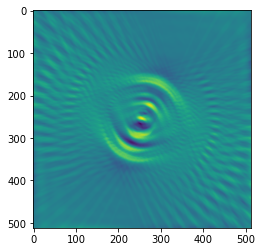

In [20]:

slice = 25
time = 2
plt.imshow(rtv[slice,time])
plt.show()